###For a given hybrid focal plane layout how much sky do we cover as a function of time###

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
import healpy as hp

In [2]:
# This is needed to avoid an error when a metric is redefined
from lsst.sims.maf.metrics import BaseMetric
try:
    del metrics.BaseMetric.registry['__main__.selectChipsMetric']
except KeyError:
    pass

In [3]:
class selectChipsMetric(BaseMetric):
    """
    Pass a set of sensors or rafts for a given vendor
    """

    def __init__(self, cols=None, sensors=None, **kwargs):
        if sensors == None:
            self.sensors = []
        else:
            self.sensors = sensors

        if cols is None:
            cols = []
        super(selectChipsMetric,self).__init__(col=cols, metricDtype=float, **kwargs)

    def _selectChips(self, chipName):
        """
        given a list of sensors increment count if a region of the sky covers that sensor 
        """
        count = 0
        for chip in chipName:
            for sensor in self.sensors:
                if sensor in chip:
                    count +=1
                    break
        return count
                
    def run(self, dataSlice, slicePoint=None):

        if 'chipNames' not in slicePoint.keys():
            raise ValueError('No chipname info, need to set useCamera=True with a spatial slicer.')

        result = self._selectChips(slicePoint['chipNames'])

        if result == 0:
            result = self.badval
        return result

In [4]:
# Set the database and query
database = 'enigma_1189_sqlite.db'
#sqlWhere = 'filter = "r" and night < 400'
opsdb = db.OpsimDatabase(database)
outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)
nside=512

In [5]:
#define rafts for a given vendor

rafts = ['R:0,1', 'R:0,2', 'R:0,3',
         'R:1,0', 'R:1,1', 'R:1,2', 'R:1,3', 'R:1,4',
         'R:2,0', 'R:2,1', 'R:2,2', 'R:2,3', 'R:2,4',
         'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
         'R:4,1', 'R:4,2', 'R:4,3',
        ]
rafts2 = ['R:0,1',  'R:0,3',
         'R:1,1', 'R:1,3', 
         'R:2,0', 'R:2,2', 'R:2,4',
         'R:3,1', 'R:3,3', 
         'R:4,1',  'R:4,3',
        ]
rafts1 = ['R:2,2', 'R:2,3', 'R:2,4',
         'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
         'R:4,0', 'R:4,1', 'R:4,2', 'R:4,3', 
        ]
metric1 = metrics.CountMetric('expMJD')
metric2 = selectChipsMetric('expMJD', sensors =rafts2)
slicer = slicers.HealpixSlicer(nside=nside, useCamera=True)
summaryMetrics = [metrics.SumMetric()]

Healpix slicer using NSIDE=512, approximate resolution 6.870973 arcminutes


In [6]:
#run metric with all sensors
sqlWhere = 'filter = "r" and expMJD < 49547.36 and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (np.radians(15.), np.radians(-15.))
#sqlWhere = 'fieldID = 2266 and expMJD < 49593.3'
bundle1 = metricBundles.MetricBundle(metric1,slicer,sqlWhere, summaryMetrics=summaryMetrics)
bundle2 = metricBundles.MetricBundle(metric2,slicer,sqlWhere, summaryMetrics=summaryMetrics)
bgFull = metricBundles.MetricBundleGroup({'Full':bundle1,'Hybrid':bundle2,},opsdb, outDir=outDir, resultsDb=resultsDb)
bgFull.runAll()
normPixels = len((np.where(bundle1.metricValues > 0))[0])

Querying database with constraint filter = "r" and expMJD < 49547.36 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Found 1 visits
Running:  ['Full', 'Hybrid']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


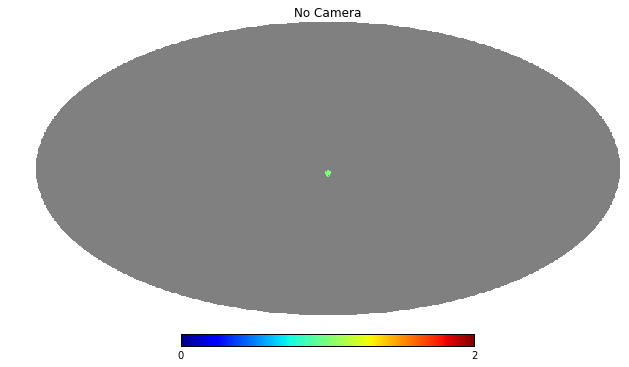

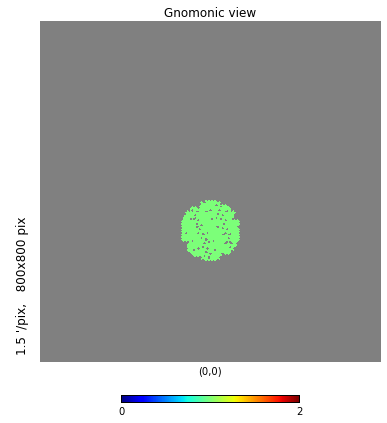

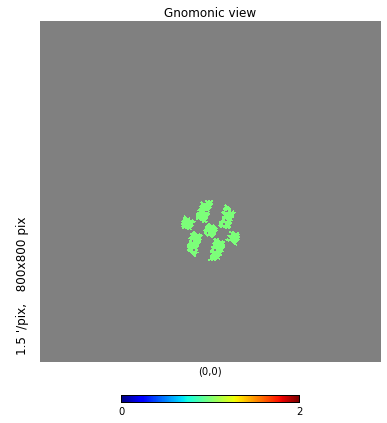

In [7]:
#plot camera
hp.mollview(bundle1.metricValues, title='No Camera')
hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(0,0,0))
hp.gnomview(bundle2.metricValues, xsize=800,ysize=800, rot=(0,0,0))
#hp.gnomview(bundle1.metricValues, xsize=400,ysize=400, rot=(48,-9,0), title='With Camera', unit='Vendor')
#hp.gnomview(bundle1.metricValues, xsize=800,ysize=800, rot=(48,-9,0))


In [8]:
#loop over seasons and calculate the depth
nSeasons = 10
seasonLength = 50
nRepeats = [1,2,4,8,10]
numPixels = np.zeros((nSeasons,len(nRepeats)))
for i in range(nSeasons):
    sqlWhere = 'filter = "r" and night < %f and fieldRA < %f and fieldDec > %f and fieldDec < 0' % (i*seasonLength,np.radians(15), np.radians(-15))
    bundle2 = metricBundles.MetricBundle(metric2,slicer,sqlWhere, summaryMetrics=summaryMetrics)
    bgHybrid = metricBundles.MetricBundleGroup({'Hybrid':bundle2},opsdb, outDir=outDir, resultsDb=resultsDb)
    bgHybrid.runAll() 
    for j,repeat in enumerate(nRepeats):
        numPixels[i,j] = len((np.where(bundle2.metricValues > repeat))[0])

Querying database with constraint filter = "r" and night < 0.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
No data matching sqlconstraint filter = "r" and night < 0.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Querying database with constraint filter = "r" and night < 50.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
No data matching sqlconstraint filter = "r" and night < 50.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Querying database with constraint filter = "r" and night < 100.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
No data matching sqlconstraint filter = "r" and night < 100.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
Querying database with constraint filter = "r" and night < 150.000000 and fieldRA < 0.261799 and fieldDec > -0.261799 and fieldDec < 0
No data matching sqlconstraint filter = "r" and night < 150.000000 and

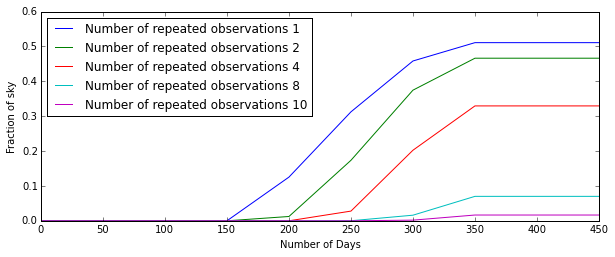

In [9]:
#plot repeats as a function of time
fig = plt.figure(figsize=(10, 3.75))
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Days')
ax.set_ylabel('Fraction of sky')
for i in range(len(nRepeats)):
    plt.plot(seasonLength*np.arange(nSeasons), numPixels[:,i]*100./normPixels, label='Number of repeated observations %d'%(nRepeats[i]))
ax.legend(loc=0)